In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Removing all the warnings
import warnings
warnings.filterwarnings('ignore')

# Set env CUDA_LAUNCH_BLOCKING=1
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Retina display
%config InlineBackend.figure_format = 'retina'

from einops import rearrange


## Task 2

### Question 1

In [2]:
if os.path.exists('cat.jpg'):
    print('cat.jpg exists')

cat.jpg exists


torch.Size([3, 300, 300])


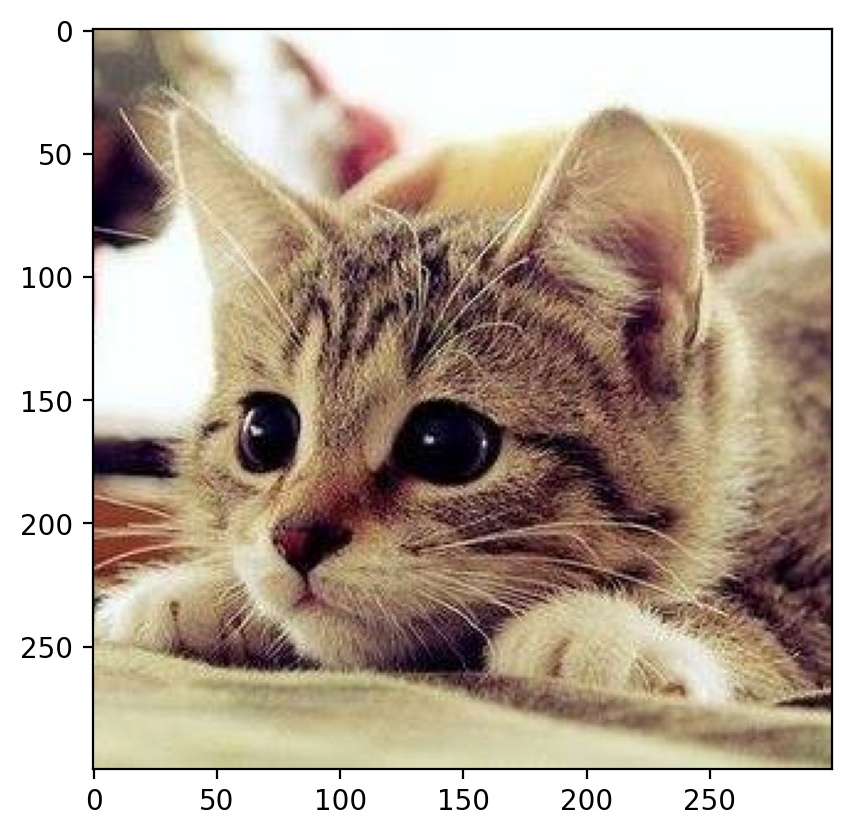

In [3]:
# Read in an image from torchvision
img = torchvision.io.read_image("cat.jpg")
print(img.shape)
plt.imshow(rearrange(img, 'c h w -> h w c').numpy())

In [4]:
from sklearn import preprocessing

scaler_img = preprocessing.MinMaxScaler().fit(img.reshape(-1, 1)) # Reshape the image to 2D array
img_scaled = scaler_img.transform(img.reshape(-1, 1)).reshape(img.shape) # Scaling and reshaping back to the original image shape
img_scaled = torch.tensor(img_scaled) # Converting image to a PyTorch tensor
img_scaled = img_scaled.to(device)
img_scaled.shape

torch.Size([3, 300, 300])

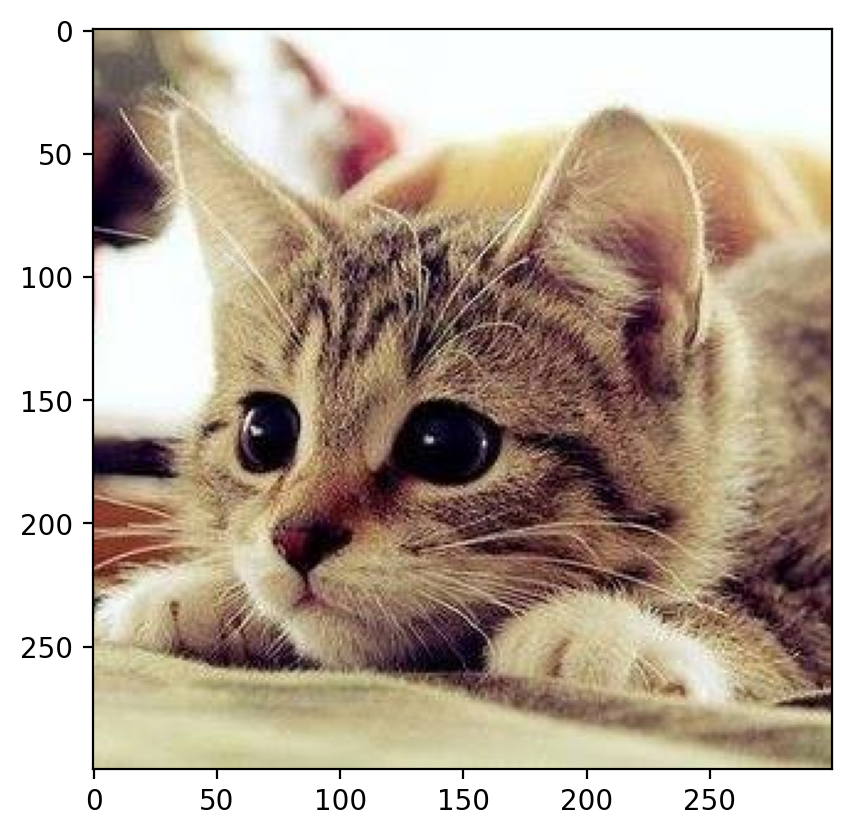

In [5]:
plt.imshow(rearrange(img_scaled, 'c h w -> h w c').cpu().numpy())

In [6]:
crop = img_scaled.to(device)

In [7]:
def create_coordinate_map(img):
    """
    img: torch.Tensor of shape (num_channels, height, width)
    
    return: tuple of torch.Tensor of shape (height * width, 2) and torch.Tensor of shape (height * width, num_channels)
    """
    
    num_channels, height, width = img.shape
    
    # Create a 2D grid of (x,y) coordinates (h, w)
    # width values change faster than height values
    w_coords = torch.arange(width).repeat(height, 1)
    h_coords = torch.arange(height).repeat(width, 1).t()
    w_coords = w_coords.reshape(-1)
    h_coords = h_coords.reshape(-1)

    # Combine the x and y coordinates into a single tensor
    X = torch.stack([h_coords, w_coords], dim=1).float()

    # Move X to GPU if available
    X = X.to(device)

    # Reshape the image to (h * w, num_channels)
    Y = rearrange(img, 'c h w -> (h w) c').float()
    return X, Y

In [8]:
img_x, img_y = create_coordinate_map(crop)

img_x.shape, img_y.shape

(torch.Size([90000, 2]), torch.Size([90000, 3]))

In [9]:
# Initialize the MinMaxScaler to scale between -1 and 1
scaler_X = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(img_x.cpu())

# Scaling the X data (scaling is done on CPU)
img_X_scaled = scaler_X.transform(img_x.cpu())

# Converting the scaled data to a PyTorch tensor
img_X_scaled = torch.tensor(img_X_scaled)

# Moving the tensor to the specified device
img_X_scaled = img_X_scaled.to(device)

# Ensuring the data type is float
img_X_scaled = img_X_scaled.float()

#### Linear Regression

In [10]:
class LinearModel(nn.Module):
    def __init__(self, in_features, out_features):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(in_features, out_features) #Linear transformation based on number of input and output features
        
    def forward(self, x): #Forward Pass - linear transformation defined in self.linear
        return self.linear(x)

In [11]:
net = LinearModel(2, 3) 
net.to(device)

LinearModel(
  (linear): Linear(in_features=2, out_features=3, bias=True)
)

In [12]:
def train(net, lr, X, Y, epochs, verbose=True):
    """
    net: torch.nn.Module
    lr: float (learning rate)
    X: torch.Tensor of shape (num_samples, 2 (X,Y))
    Y: torch.Tensor of shape (num_samples, 3 (R,G,B))
    """

    criterion = nn.MSELoss() #Mean squared error loss function
    optimizer = torch.optim.Adam(net.parameters(), lr=lr) 
    for epoch in range(epochs):
        optimizer.zero_grad() #Initialize to zero

        # Computing the loss
        outputs = net(X)
        loss = criterion(outputs, Y)
        loss.backward()

        # Updating the parameters
        optimizer.step()

        # Printing the loss for each epoch (for testing)
        if verbose and epoch % 100 == 0:
            print(f"Epoch {epoch} loss: {loss.item():.6f}")

    return loss.item()

In [13]:
mse=train(net, 0.01, img_X_scaled, img_y, 1000)
print("Mean Squared Error: ",mse)

Epoch 0 loss: 0.431024
Epoch 100 loss: 0.066128
Epoch 200 loss: 0.063878
Epoch 300 loss: 0.063878
Epoch 400 loss: 0.063878
Epoch 500 loss: 0.063878
Epoch 600 loss: 0.063878
Epoch 700 loss: 0.063878
Epoch 800 loss: 0.063878
Epoch 900 loss: 0.063878
Mean Squared Error:  0.06387808918952942


In [14]:
def psnr(mse):
    return  20 * np.log10(255/np.sqrt(mse))

In [15]:
print("Peak Signal-to-Noise Ratio: ",psnr(mse))

Peak Signal-to-Noise Ratio:  60.07728444429253


In [16]:
def plot_reconstructed_and_original_image(original_img, net, X, title=""):
    """
    net: torch.nn.Module
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """

    num_channels, height, width = original_img.shape
    net.eval() #Set to evaluation
    
    with torch.no_grad(): #Disables gradient calculation
        outputs = net(X)
        outputs = outputs.reshape(height, width, num_channels)
    
    #Plotting the figures
    fig = plt.figure(figsize=(12, 8))
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])

    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])

    ax0.imshow(outputs.cpu())
    ax0.set_title("Reconstructed Image", fontfamily='serif')
    

    ax1.imshow(original_img.cpu().permute(1, 2, 0))
    ax1.set_title("Original Image", fontfamily='serif')
    
    for a in [ax0, ax1]:
        a.axis("off")


    fig.suptitle(title, size=18, fontfamily='serif', y=1)
    plt.tight_layout()

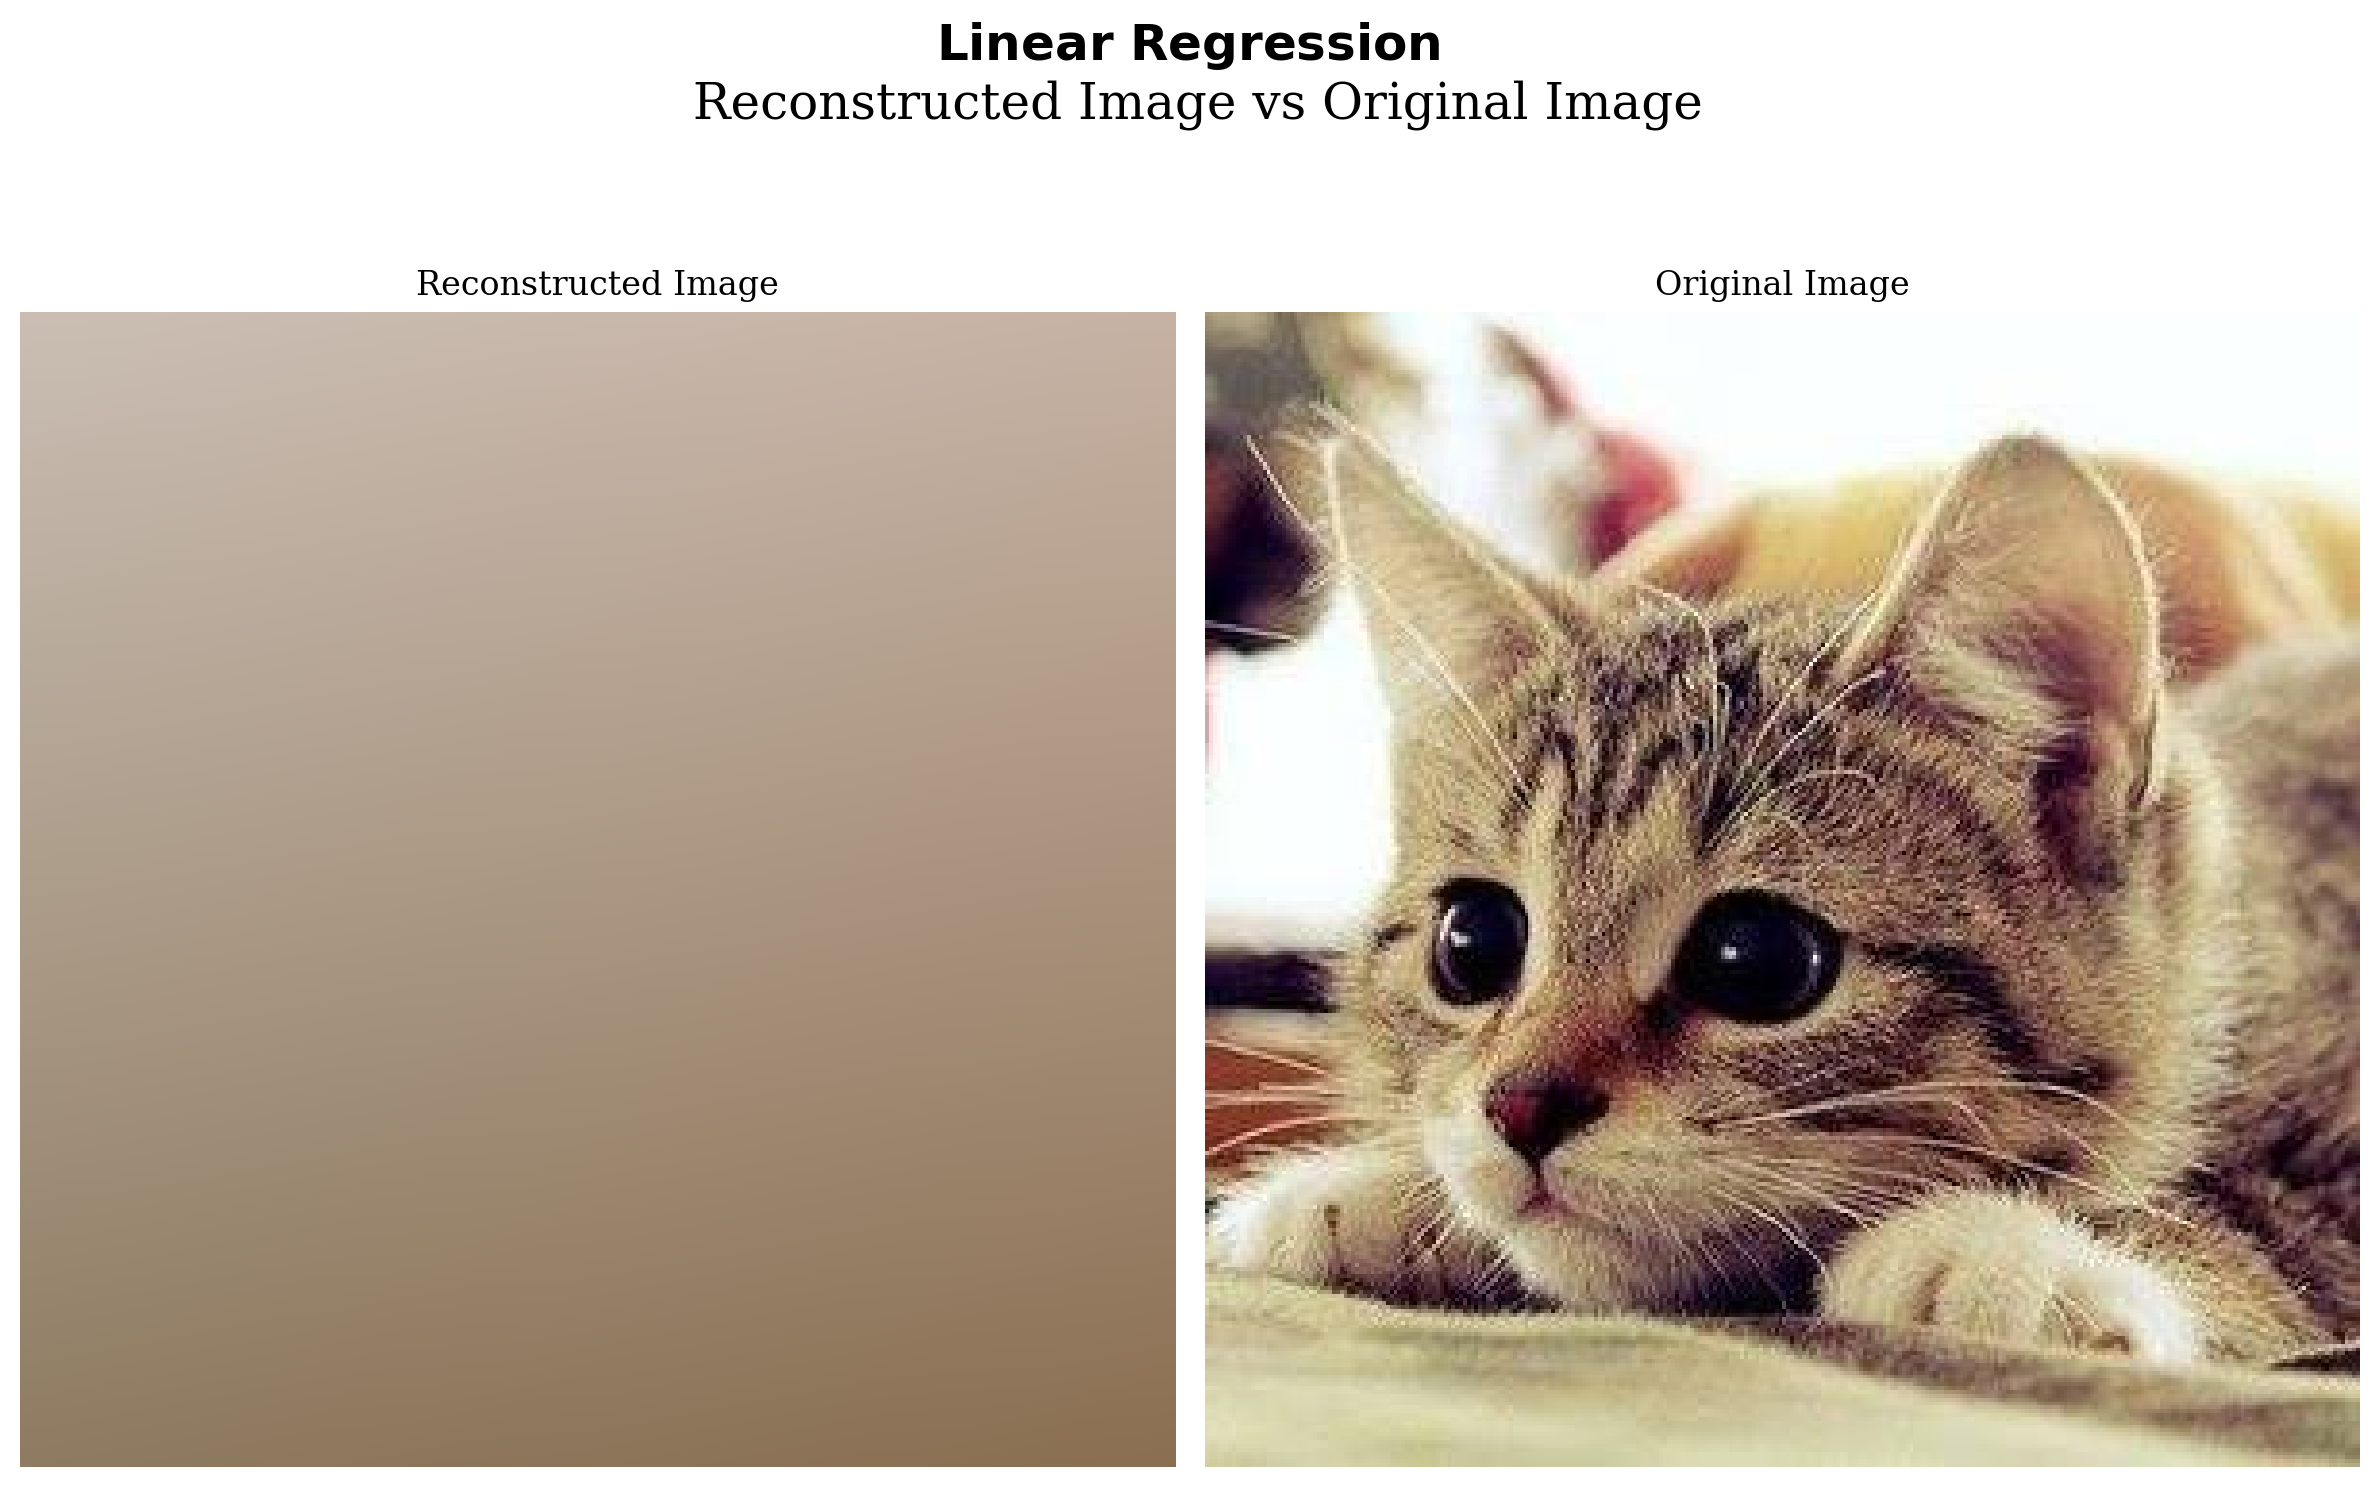

In [17]:
plot_reconstructed_and_original_image(crop, net, img_X_scaled, title="$\\bf{Linear\ Regression}$ \n Reconstructed Image vs Original Image")

#### Random Fourier Features

In [18]:
def create_rff_features(X, num_features, sigma):
    from sklearn.kernel_approximation import RBFSampler
    rff = RBFSampler(n_components=num_features, gamma=1/(2 * sigma**2)) #Creating random fourier features
    X = X.cpu().numpy() #Converting to numpy array
    X = rff.fit_transform(X)
    return torch.tensor(X, dtype=torch.float32).to(device)

In [19]:
X_rff = create_rff_features(img_X_scaled, 15000, 0.008) #15000 fourier features and gamma=0.008
X_rff.shape

torch.Size([90000, 15000])

In [20]:
net = LinearModel(X_rff.shape[1], 3) 
net.to(device)

mse=train(net, 0.05, X_rff, img_y, 500) #Learning rate = 0.05 and epochs = 500
print("Mean Squared Error: ",mse)

Epoch 0 loss: 0.426547
Epoch 100 loss: 0.007952
Epoch 200 loss: 0.004806
Epoch 300 loss: 0.004173
Epoch 400 loss: 0.003984
Mean Squared Error:  0.003915816079825163


In [21]:
print("Peak Signal-to-Noise Ratio: ",psnr(mse))

Peak Signal-to-Noise Ratio:  72.20258075436716


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.07697874..1.1073947].


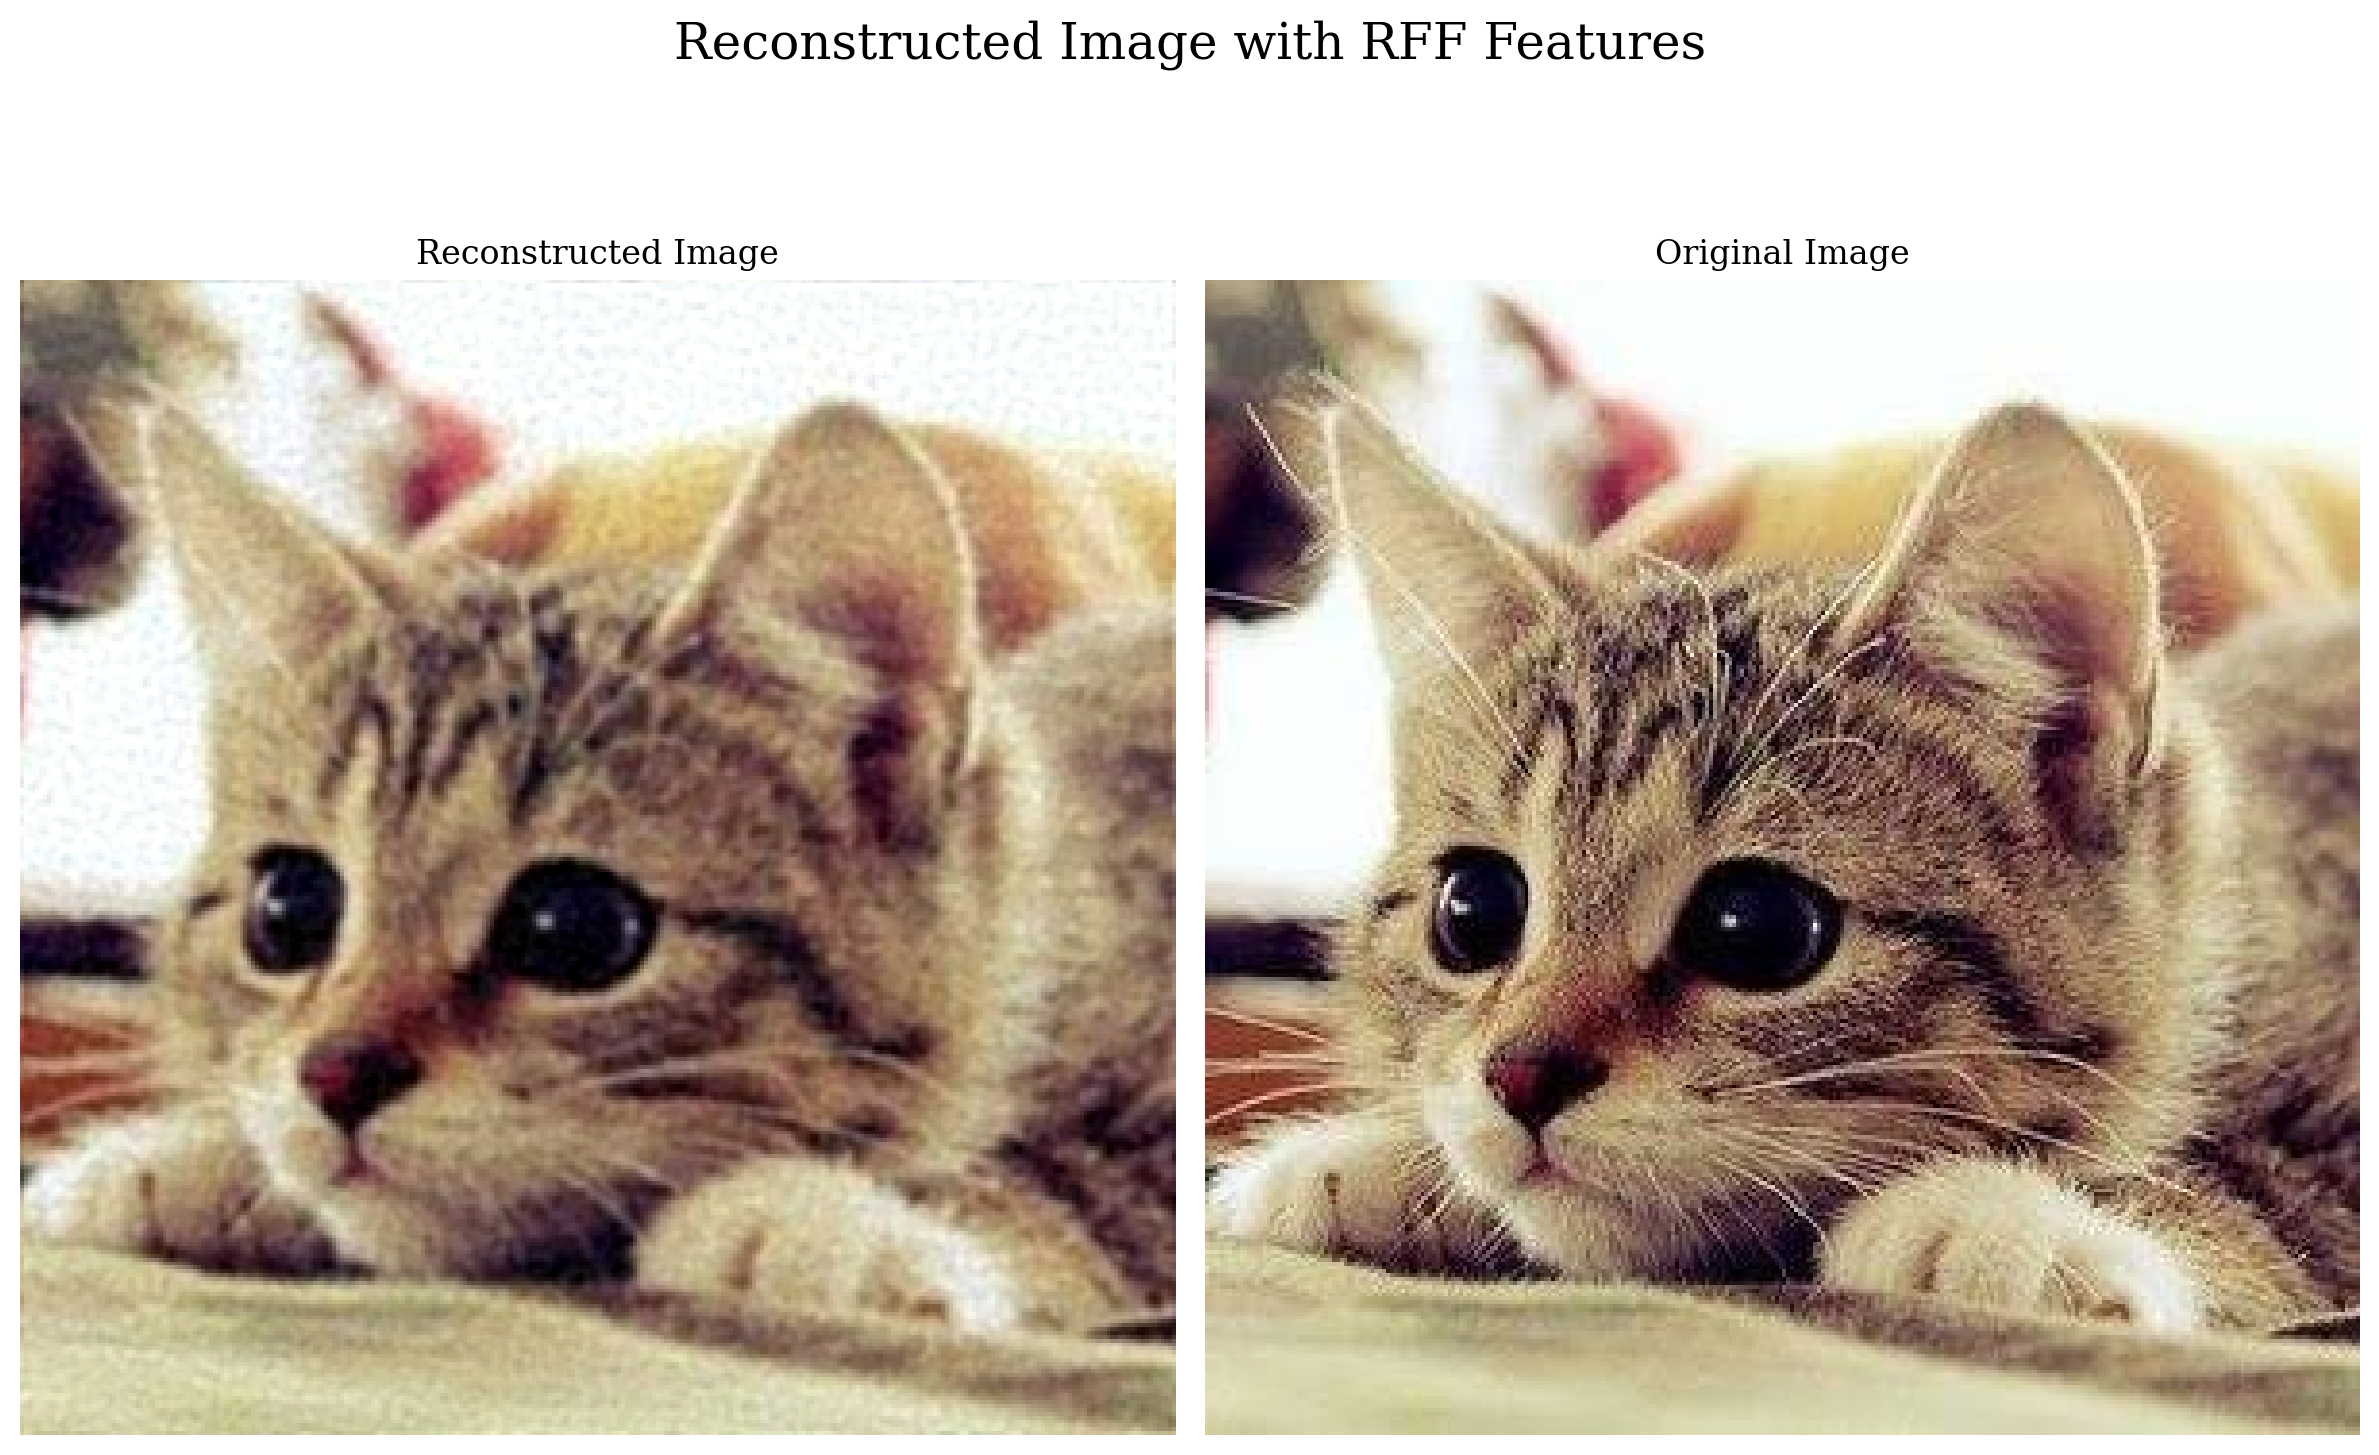

In [22]:
plot_reconstructed_and_original_image(crop, net, X_rff, title="Reconstructed Image with RFF Features")

### Question 2

In [23]:
from latexify import latexify
latexify(columns = 2)

In [24]:
import soundfile

%matplotlib inline
%config InlineBackend.figure_format = "retina"

if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
    
print(device)

cpu
